In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch 

In [3]:
import numpy as np
from tqdm.notebook import tqdm

In [4]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
 
%matplotlib inline

In [5]:
os.listdir("/content/drive/MyDrive/data/images/")

['Images']

In [37]:
IMAGE_SIZE = 64
BATCH_SIZE = 500
STATS = (.5, .5, .5), (.5, .5, .5)
DATA_DIR = '/content/drive/MyDrive/data/images/'

In [38]:
train_ds = ImageFolder(DATA_DIR, transform= T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize((.5, .5, .5), (.5, .5, .5))
]))

In [39]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

In [40]:
img, _ = next(iter(train_dl))
img.shape

torch.Size([500, 3, 64, 64])

In [41]:
def denorm(img_tensor):
    return img_tensor * STATS[1][0] + STATS[0][0]

In [42]:
def showImages(images):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach())).permute(1, 2, 0))

def showBatch(dl):
    for images, _ in dl:
        showImages(images)
        break

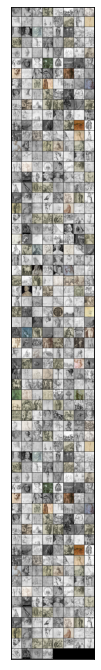

In [43]:
showBatch(train_dl)

In [44]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [14]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [45]:
train_dl = DeviceDataLoader(train_dl, device)

In [17]:
import torch.optim as optim

In [18]:
from torchvision.utils import save_image

In [19]:
class GeneratorModel(nn.Module):
  
  def __init__(self):
    super(GeneratorModel, self).__init__()
    input_dim = 128
    output_dim = 512
    
    self.hidden_layer1 = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(input_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    )
    self.hidden_layer2 = nn.Sequential(
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    )
    self.hidden_layer3 = nn.Sequential(
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    )
    self.hidden_layer4 = nn.Sequential(
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    )
    self.output_layer = nn.Sequential(
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    )
    
  def forward(self, x):

    output = self.hidden_layer1(x)
    output = self.hidden_layer2(output)
    output = self.hidden_layer3(output)
    output = self.hidden_layer4(output)
    output = self.output_layer(output)
    output = to_device(output,device)
    return output

In [20]:
class DiscriminatorModel(nn.Module):
  
  def __init__(self):
    super(DiscriminatorModel, self).__init__()
   
    self.hidden_layer1 = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    )
    self.hidden_layer2 = nn.Sequential(
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16
    )
    self.hidden_layer3 = nn.Sequential(
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    )
    self.hidden_layer4 = nn.Sequential(
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    )
    self.output_layer = nn.Sequential(
    nn.Conv2d(512, 1,  kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
    )
    
  def forward(self, x):
   
    output = self.hidden_layer1(x)
    output = self.hidden_layer2(output)
    output = self.hidden_layer3(output)
    output = self.hidden_layer4(output)
    output = self.output_layer(output)
    output = to_device(output,device)
    return output

In [ ]:
discriminator = DiscriminatorModel()
generator = GeneratorModel()
discriminator = to_device(discriminator,device)
generator = to_device(generator,device)

In [46]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
    nn.Conv2d(512, 1,  kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [47]:
discriminator = to_device(discriminator, device)

In [48]:

generator  = nn.Sequential(
  
    
    # in: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(3, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [49]:

generator = to_device(generator, device)

In [50]:
def train_discriminator(real_image, gen_input, opt_d):
  opt_d.zero_grad()

  #Pass real Image through discriminator
  real_image = real_image.to(device)
  real_preds = discriminator(real_image)
  real_targets = torch.ones(real_image.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #Generate fake images from text description
  fake_images = generator(gen_input)

  #Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward(retain_graph=True)
  opt_d.step()
  return loss.item(), real_score, fake_score

In [51]:
def train_generator(gen_input, opt_g):
  opt_g.zero_grad()

  #Generate fake images from text description
  fake_images = generator(gen_input)

  #Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(gen_input.size(0), 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #Update generator weights
  loss.backward(retain_graph=True)
  opt_g.step()

  return loss.item()

In [27]:
from torchvision.utils import save_image

In [28]:

save_dir = '/content/drive/MyDrive/data/Generated/Images'
os.makedirs(save_dir, exist_ok = True)

In [52]:
def save_sample(index, gen_input, show=True):
    fake_images = generator(gen_input)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(save_dir, fake_fname))
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()).permute(1, 2, 0))

torch.Size([500, 3, 64, 64])


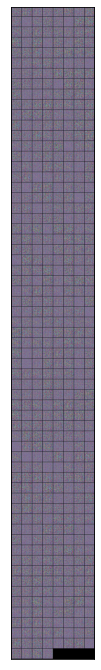

In [53]:
noise = torch.randn(500, 3, 1, 1)
noise = to_device(noise,device)
fake_image = generator(noise)
print(fake_image.shape)
showImages(fake_image)

In [54]:
import torch.nn.functional as F

In [55]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    #Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        
        for i, (real_images, _) in tqdm(enumerate(train_dl)):
            # Train discriminator 
            noise = torch.randn(500, 3, 1, 1).to(device)
            loss_d, real_score, fake_score = train_discriminator(real_image=real_images, gen_input=noise , opt_d=opt_d)
            loss_g = train_generator(gen_input=noise, opt_g=opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save Generated images
        save_sample(epoch+start_idx, noise, show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [56]:
lr = 1e-4
epochs = 150

In [57]:
history = fit(epochs, lr)

KeyboardInterrupt: ignored

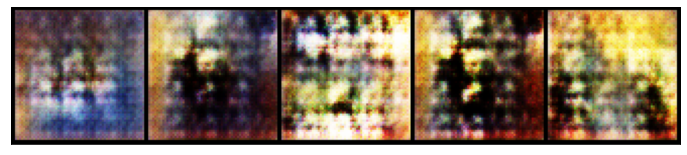

In [ ]:
noise = torch.randn(5, 3, 1, 1).to(device)
pred_img = generator(noise)
showImages(pred_img)

In [58]:
model_dir = '/content/drive/MyDrive/data/model'
os.makedirs(model_dir, exist_ok=True)

In [59]:
torch.save(generator.state_dict(), os.path.join(model_dir, 'generator18.pth'))
torch.save(discriminator.state_dict(), os.path.join(model_dir, 'discriminator18.pth'))

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

NameError: ignored

In [ ]:
len(losses_g), len(losses_g), len(real_scores), len(fake_scores)

In [ ]:
losses_g = np.array(losses_g)
np.save(os.path.join(model_dir, 'losses_g.npy'), losses_g)

In [ ]:
losses_d = np.array(losses_d)
np.save(os.path.join(model_dir, 'losses_d.npy'), losses_d)

real_scores = np.array(real_scores)
np.save(os.path.join(model_dir,'real_scores.npy'), real_scores)

fake_scores = np.array(fake_scores)
np.save(os.path.join(model_dir, 'fake_scores.npy'), fake_scores)

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.savefig(os.path.join(model_dir, 'losses.png'))

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')
plt.savefig(os.path.join(model_dir, 'scores.png'))

In [ ]:
generator.load_state_dict(torch.load(os.path.join(model_dir, 'generator18.pth')))

<All keys matched successfully>

In [ ]:
generator.eval()

Sequential(
  (0): ConvTranspose2d(3, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

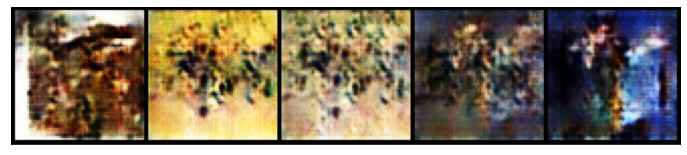

In [ ]:
noise = torch.randn(5, 3, 1, 1).to(device)
pred_img = generator(noise)
showImages(pred_img)